# 04 — Chokepoint Vulnerability Analysis & Fusion Pipeline

Objective: Integrate daily chokepoint-level datasets — maritime traffic, weather stress, and geopolitical risk — into a unified analytical framework. Compute a multi-factor Vulnerability Index that quantifies relative chokepoint exposure to operational disruptions. Produce merged dataset and diagnostic visualizations.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

traffic_data_dir = 'processed_ais_data'
processed_data_dir = 'processed_data'

traffic_files = [f for f in os.listdir(traffic_data_dir) if f.startswith('chokepoints_daily_data')]
latest_traffic_file = sorted(traffic_files, reverse=True)[0]
traffic_file_path = os.path.join(traffic_data_dir, latest_traffic_file)

weather_file_path = os.path.join(processed_data_dir, 'daily_weather_stress.csv')
geopolitical_file_path = os.path.join('gdelt_daily_chokepoints.csv')

df_traffic = pd.read_csv(traffic_file_path)
print(f"Traffic data loaded from: {traffic_file_path}")

df_weather = pd.read_csv(weather_file_path)
print(f"Weather data loaded from: {weather_file_path}")

df_geopolitical = pd.read_csv(geopolitical_file_path)
print(f"Geopolitical data loaded from: {geopolitical_file_path}")

print("\nAll three data files loaded successfully.")

Traffic data loaded from: processed_ais_data/chokepoints_daily_data_2025_10_14.csv
Weather data loaded from: processed_data/daily_weather_stress.csv
Geopolitical data loaded from: gdelt_daily_chokepoints.csv

All three data files loaded successfully.


In [ ]:
print(f"Traffic data shape:      {df_traffic.shape}")
print(f"Weather data shape:      {df_weather.shape}")
print(f"Geopolitical data shape: {df_geopolitical.shape}")

print("\n--- Traffic Data Sample ---")
display(df_traffic.head(2))
print("\n--- Weather Data Sample ---")
display(df_weather.head(2))
print("\n--- Geopolitical Data Sample ---")
display(df_geopolitical.head(2))

Traffic data shape:      (12385, 10)
Weather data shape:      (12375, 5)
Geopolitical data shape: (12405, 12)

--- Traffic Data Sample ---


,date,chokepoint_id,chokepoint_name,n_total,n_container,n_dry_bulk,n_general_cargo,n_roro,n_tanker,capacity
0,2019-01-01 05:30:00,cp_bab_el_mandeb,Bab el-Mandeb Strait,50,16,8,4,1,21,2.742136e+06
1,2019-01-02 05:30:00,cp_bab_el_mandeb,Bab el-Mandeb Strait,59,18,16,6,1,18,2.780443e+06



--- Weather Data Sample ---


,date,chokepoint_id,chokepoint_name,weather_stress_score,wave_height
0,2025-03-01,cp_bab_el_mandeb,Bab el-Mandeb Strait,0.347671,0.898816
1,2025-03-02,cp_bab_el_mandeb,Bab el-Mandeb Strait,0.183501,0.555455



--- Geopolitical Data Sample ---


,date,chokepoint_id,event_count,event_count_smoothed,event_count_30d,goldstein_mean,goldstein_smoothed,goldstein_min,goldstein_max,goldstein_sum,has_events,geopolitical_risk_score
0,2019-01-01,cp_bab_el_mandeb,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0,0.00
1,2019-01-01,cp_bosporus,54.0,87.25,54.0,-9.925926,-9.947219,-10.0,-9.0,-536.0,1,51.41


In [ ]:
print("--- Preparing datasets for unification ---")

# Convert all date columns to datetime objects
df_traffic['date'] = pd.to_datetime(df_traffic['date']).dt.date
df_traffic['date'] = pd.to_datetime(df_traffic['date'])

df_weather['date'] = pd.to_datetime(df_weather['date']).dt.date
df_weather['date'] = pd.to_datetime(df_weather['date'])

df_geopolitical['date'] = pd.to_datetime(df_geopolitical['date']).dt.date
df_geopolitical['date'] = pd.to_datetime(df_geopolitical['date'])

print("✓ Dates normalized (time component removed)")

if 'risk_score_zscore' not in df_geopolitical.columns:
    print("\nWARNING: 'risk_score_zscore' not found in geopolitical data. Calculating it now...")
    
    balanced_dfs = []
    # Loop through each chokepoint to calculate its own unique Z-score
    for cp_id, group in df_geopolitical.groupby('chokepoint_id'):
        df_chokepoint = group.copy()
        mean_score = df_chokepoint['geopolitical_risk_score'].mean()
        std_score = df_chokepoint['geopolitical_risk_score'].std()
        
        if std_score > 0:
            df_chokepoint['risk_score_zscore'] = (df_chokepoint['geopolitical_risk_score'] - mean_score) / std_score
        else:
            df_chokepoint['risk_score_zscore'] = 0
        balanced_dfs.append(df_chokepoint)
        
    # Overwrite the original df_geopolitical with the version that has the z-score
    df_geopolitical = pd.concat(balanced_dfs, ignore_index=True)
    print("✓ 'risk_score_zscore' column successfully created.")

df_traffic_clean = df_traffic[['date', 'chokepoint_id', 'n_total']].copy().drop_duplicates()
df_weather_clean = df_weather[['date', 'chokepoint_id', 'weather_stress_score']].copy()

# Aggregate weather to daily level if multiple entries per day
df_weather_clean = df_weather_clean.groupby(['date', 'chokepoint_id'])['weather_stress_score'].mean().reset_index()

df_geopolitical_clean = df_geopolitical[['date', 'chokepoint_id', 'risk_score_zscore']].copy().drop_duplicates()

print("\n✓ All datasets are clean and ready for merging.")

--- Preparing datasets for unification ---
✓ Dates normalized (time component removed)

✓ All datasets are clean and ready for merging.


In [26]:
# Diagnostic Check
print("\n=== DIAGNOSTIC: Checking Date Ranges ===")
print(f"Traffic dates: {df_traffic_clean['date'].min()} to {df_traffic_clean['date'].max()}")
print(f"Weather dates: {df_weather_clean['date'].min()} to {df_weather_clean['date'].max()}")
print(f"Geopolitical dates: {df_geopolitical_clean['date'].min()} to {df_geopolitical_clean['date'].max()}")

print("\n=== DIAGNOSTIC: Checking Chokepoint IDs ===")
print(f"Traffic chokepoints: {sorted(df_traffic_clean['chokepoint_id'].unique())}")
print(f"Weather chokepoints: {sorted(df_weather_clean['chokepoint_id'].unique())}")
print(f"Geopolitical chokepoints: {sorted(df_geopolitical_clean['chokepoint_id'].unique())}")

print("\n=== DIAGNOSTIC: Sample row counts per dataset ===")
print(f"Traffic rows: {len(df_traffic_clean)}")
print(f"Weather rows: {len(df_weather_clean)}")
print(f"Geopolitical rows: {len(df_geopolitical_clean)}")


=== DIAGNOSTIC: Checking Date Ranges ===
Traffic dates: 2019-01-01 00:00:00 to 2025-10-12 00:00:00
Weather dates: 2019-01-01 00:00:00 to 2025-10-10 00:00:00
Geopolitical dates: 2019-01-01 00:00:00 to 2025-10-16 00:00:00

=== DIAGNOSTIC: Checking Chokepoint IDs ===
Traffic chokepoints: ['cp_bab_el_mandeb', 'cp_bosporus', 'cp_malacca', 'cp_panama', 'cp_suez']
Weather chokepoints: ['cp_bab_el_mandeb', 'cp_bosporus', 'cp_malacca', 'cp_panama', 'cp_suez']
Geopolitical chokepoints: ['cp_bab_el_mandeb', 'cp_bosporus', 'cp_malacca', 'cp_panama', 'cp_suez']

=== DIAGNOSTIC: Sample row counts per dataset ===
Traffic rows: 12385
Weather rows: 12375
Geopolitical rows: 12405


In [ ]:
definitions_file = os.path.join(processed_data_dir, 'chokepoint_definitions.csv')
df_definitions = pd.read_csv(definitions_file)
print(f"\nChokepoint definitions loaded from: {definitions_file}")

print("--- Starting the Grand Unification ---")

# Merge Traffic and Weather Data
print("Step 1: Merging Traffic and Weather...")
master_df = pd.merge(
    df_traffic_clean,
    df_weather_clean,
    on=['date', 'chokepoint_id'],
    how='inner'
)
print(f"  After Traffic + Weather merge: {len(master_df):,} rows")

# Merge the Result with Geopolitical Data
print("Step 2: Merging with Geopolitical data...")
master_df = pd.merge(
    master_df,
    df_geopolitical_clean,
    on=['date', 'chokepoint_id'],
    how='inner'
)
print(f"  After adding Geopolitical data: {len(master_df):,} rows")

# Post-Merge Cleanup and Verification
master_df = master_df.sort_values(by=['chokepoint_id', 'date']).reset_index(drop=True)

# Add the chokepoint names from our official definitions file
master_df = pd.merge(master_df, df_definitions[['chokepoint_id', 'chokepoint_name']], on='chokepoint_id', how='left')

print("\n--- Grand Unification Complete! ---")
print("Checking for missing values (should be zero):")
print(master_df.isnull().sum())

print(f"\nMaster DataFrame has {len(master_df):,} rows.")
if len(master_df) > 0:
    print(f"Date range: {master_df['date'].min().date()} to {master_df['date'].max().date()}")
    print(f"Chokepoints included: {sorted(master_df['chokepoint_name'].unique())}")
    display(master_df.head())
else:
    print("ERROR: Master DataFrame is empty! Check the diagnostic output above.")


Chokepoint definitions loaded from: processed_data/chokepoint_definitions.csv
--- Starting the Grand Unification ---
Step 1: Merging Traffic and Weather...
  After Traffic + Weather merge: 12,375 rows
Step 2: Merging with Geopolitical data...
  After adding Geopolitical data: 12,375 rows

--- Grand Unification Complete! ---
Checking for missing values (should be zero):
date                    0
chokepoint_id           0
n_total                 0
weather_stress_score    0
risk_score_zscore       0
chokepoint_name         0
dtype: int64

Master DataFrame has 12,375 rows.
Date range: 2019-01-01 to 2025-10-10
Chokepoints included: ['Bab el-Mandeb Strait', 'Bosporus Strait', 'Malacca Strait', 'Panama Canal', 'Suez Canal']


,date,chokepoint_id,n_total,weather_stress_score,risk_score_zscore,chokepoint_name
0,2019-01-01,cp_bab_el_mandeb,50,0.374122,-0.762001,Bab el-Mandeb Strait
1,2019-01-02,cp_bab_el_mandeb,59,0.606571,-0.762001,Bab el-Mandeb Strait
2,2019-01-03,cp_bab_el_mandeb,58,0.602818,-0.762001,Bab el-Mandeb Strait
3,2019-01-04,cp_bab_el_mandeb,47,0.406080,-0.380063,Bab el-Mandeb Strait
4,2019-01-05,cp_bab_el_mandeb,74,0.350529,-0.380063,Bab el-Mandeb Strait


In [ ]:
print("=" * 70)
print("VULNERABILITY INDEX CALCULATION v2.0")
print("=" * 70)

# Normalize Traffic Data (Per Chokepoint Z-Score)
print("\n[1/4] Calculating Traffic Stress Scores...")

balanced_traffic_dfs = []
for cp_id in master_df['chokepoint_id'].unique():
    df_chokepoint = master_df[master_df['chokepoint_id'] == cp_id].copy()
    
    mean_traffic = df_chokepoint['n_total'].mean()
    std_traffic = df_chokepoint['n_total'].std()
    
    if std_traffic > 0:
        # NEGATIVE Z-score: Lower traffic = Higher stress/vulnerability
        df_chokepoint['traffic_stress_score'] = -((df_chokepoint['n_total'] - mean_traffic) / std_traffic)
    else:
        df_chokepoint['traffic_stress_score'] = 0
        
    balanced_traffic_dfs.append(df_chokepoint)

master_df = pd.concat(balanced_traffic_dfs, ignore_index=True).sort_values(by=['chokepoint_id', 'date']).reset_index(drop=True)
print(f"✓ Traffic stress calculated for {len(master_df['chokepoint_id'].unique())} chokepoints")

# Normalize All Components to 0-1 Scale
print("\n[2/4] Normalizing all components to 0-1 scale...")

def min_max_normalize(series):
    """Min-Max normalization: scales values to 0-1 range"""
    min_val = series.min()
    max_val = series.max()
    if max_val > min_val:
        return (series - min_val) / (max_val - min_val)
    else:
        return pd.Series([0.5] * len(series), index=series.index)  # If constant, return 0.5

# Normalize each component
master_df['norm_traffic_stress'] = min_max_normalize(master_df['traffic_stress_score'])
master_df['norm_geopolitical_risk'] = min_max_normalize(master_df['risk_score_zscore'])
master_df['norm_weather_stress'] = master_df['weather_stress_score']  # Already 0-1

print("✓ All components normalized:")
print(f"  - Traffic Stress:      range [{master_df['norm_traffic_stress'].min():.3f}, {master_df['norm_traffic_stress'].max():.3f}]")
print(f"  - Weather Stress:      range [{master_df['norm_weather_stress'].min():.3f}, {master_df['norm_weather_stress'].max():.3f}]")
print(f"  - Geopolitical Risk:   range [{master_df['norm_geopolitical_risk'].min():.3f}, {master_df['norm_geopolitical_risk'].max():.3f}]")

# Calculate Composite Vulnerability Index
print("\n[3/4] Creating Composite Vulnerability Index...")

# Define weights (must sum to 1.0)
W_TRAFFIC = 0.35        # Traffic disruptions slightly more important
W_WEATHER = 0.30        # Weather impacts
W_GEOPOLITICAL = 0.35   # Geopolitical tensions

print(f"Weights: Traffic={W_TRAFFIC}, Weather={W_WEATHER}, Geopolitical={W_GEOPOLITICAL}")

# Calculate weighted composite index
master_df['vulnerability_index'] = (
    master_df['norm_traffic_stress'] * W_TRAFFIC +
    master_df['norm_weather_stress'] * W_WEATHER +
    master_df['norm_geopolitical_risk'] * W_GEOPOLITICAL
)

print(f"✓ Vulnerability Index calculated")
print(f"  - Range: [{master_df['vulnerability_index'].min():.3f}, {master_df['vulnerability_index'].max():.3f}]")
print(f"  - Mean: {master_df['vulnerability_index'].mean():.3f}")
print(f"  - Std Dev: {master_df['vulnerability_index'].std():.3f}")

# Add Risk Categories
print("\n[4/4] Categorizing vulnerability levels...")

# Create risk categories based on percentiles
master_df['risk_category'] = pd.cut(
    master_df['vulnerability_index'],
    bins=[0, 0.25, 0.50, 0.75, 1.0],
    labels=['Low', 'Moderate', 'High', 'Critical'],
    include_lowest=True
)

print("✓ Risk categories assigned")
print("\nDistribution of Risk Levels:")
print(master_df['risk_category'].value_counts().sort_index())

# Summary Statistics
print("\n" + "=" * 70)
print("VULNERABILITY INDEX SUMMARY")
print("=" * 70)

summary_cols = ['date', 'chokepoint_name', 'n_total', 
                'norm_traffic_stress', 'norm_weather_stress', 
                'norm_geopolitical_risk', 'vulnerability_index', 'risk_category']

print("\nSample of Calculated Vulnerability Index:")
display(master_df[summary_cols].head(10))

print("\n--- Average Vulnerability by Chokepoint ---")
avg_vuln = master_df.groupby('chokepoint_name')['vulnerability_index'].agg(['mean', 'std', 'min', 'max'])
avg_vuln = avg_vuln.sort_values('mean', ascending=False)
display(avg_vuln.round(3))

print("\n--- Top 10 Most Vulnerable Days (Across All Chokepoints) ---")
top_vulnerable = master_df.nlargest(10, 'vulnerability_index')[summary_cols]
display(top_vulnerable)

print("\n✓ Vulnerability Index Calculation Complete!")

VULNERABILITY INDEX CALCULATION v2.0

[1/4] Calculating Traffic Stress Scores...
✓ Traffic stress calculated for 5 chokepoints

[2/4] Normalizing all components to 0-1 scale...
✓ All components normalized:
  - Traffic Stress:      range [0.000, 1.000]
  - Weather Stress:      range [0.000, 1.000]
  - Geopolitical Risk:   range [0.000, 1.000]

[3/4] Creating Composite Vulnerability Index...
Weights: Traffic=0.35, Weather=0.3, Geopolitical=0.35
✓ Vulnerability Index calculated
  - Range: [0.148, 0.825]
  - Mean: 0.384
  - Std Dev: 0.076

[4/4] Categorizing vulnerability levels...
✓ Risk categories assigned

Distribution of Risk Levels:
risk_category
Low           160
Moderate    11248
High          966
Critical        1
Name: count, dtype: int64

VULNERABILITY INDEX SUMMARY

Sample of Calculated Vulnerability Index:


,date,chokepoint_name,n_total,norm_traffic_stress,norm_weather_stress,norm_geopolitical_risk,vulnerability_index,risk_category
0,2019-01-01,Bab el-Mandeb Strait,50,0.395246,0.374122,0.440272,0.404668,Moderate
1,2019-01-02,Bab el-Mandeb Strait,59,0.333655,0.606571,0.440272,0.452846,Moderate
2,2019-01-03,Bab el-Mandeb Strait,58,0.340499,0.602818,0.440272,0.454115,Moderate
3,2019-01-04,Bab el-Mandeb Strait,47,0.415776,0.406080,0.480265,0.435438,Moderate
4,2019-01-05,Bab el-Mandeb Strait,74,0.231004,0.350529,0.480265,0.354103,Moderate
5,2019-01-06,Bab el-Mandeb Strait,51,0.388402,0.330323,0.480265,0.403130,Moderate
6,2019-01-07,Bab el-Mandeb Strait,60,0.326812,0.399314,0.531516,0.420209,Moderate
7,2019-01-08,Bab el-Mandeb Strait,50,0.395246,0.302680,0.571508,0.429168,Moderate
8,2019-01-09,Bab el-Mandeb Strait,48,0.408933,0.290323,0.571508,0.430251,Moderate
9,2019-01-10,Bab el-Mandeb Strait,40,0.463680,0.269054,0.622703,0.460950,Moderate



--- Average Vulnerability by Chokepoint ---


,mean,std,min,max
chokepoint_name,,,,
Bab el-Mandeb Strait,0.420,0.085,0.207,0.720
Panama Canal,0.407,0.073,0.174,0.693
Malacca Strait,0.368,0.066,0.220,0.648
Suez Canal,0.367,0.067,0.179,0.710
Bosporus Strait,0.357,0.066,0.148,0.825



--- Top 10 Most Vulnerable Days (Across All Chokepoints) ---


,date,chokepoint_name,n_total,norm_traffic_stress,norm_weather_stress,norm_geopolitical_risk,vulnerability_index,risk_category
4258,2023-11-19,Bosporus Strait,8,0.947712,1.000000,0.552491,0.825071,Critical
1871,2024-02-15,Bab el-Mandeb Strait,33,0.511584,0.822017,0.840366,0.719788,High
10678,2021-02-17,Suez Canal,50,0.406278,0.965037,0.794334,0.709726,High
1870,2024-02-14,Bab el-Mandeb Strait,32,0.518427,0.778958,0.840366,0.709265,High
1865,2024-02-09,Bab el-Mandeb Strait,30,0.532114,0.743996,0.837845,0.702685,High
2846,2020-01-07,Bosporus Strait,26,0.830065,0.705506,0.568425,0.701123,High
1887,2024-03-02,Bab el-Mandeb Strait,29,0.538957,0.715196,0.840366,0.697322,High
1864,2024-02-08,Bab el-Mandeb Strait,29,0.538957,0.749149,0.797853,0.692628,High
9273,2024-01-23,Panama Canal,15,0.788871,0.733648,0.560949,0.692531,High
2280,2025-03-30,Bab el-Mandeb Strait,32,0.518427,0.716394,0.840366,0.690496,High



✓ Vulnerability Index Calculation Complete!


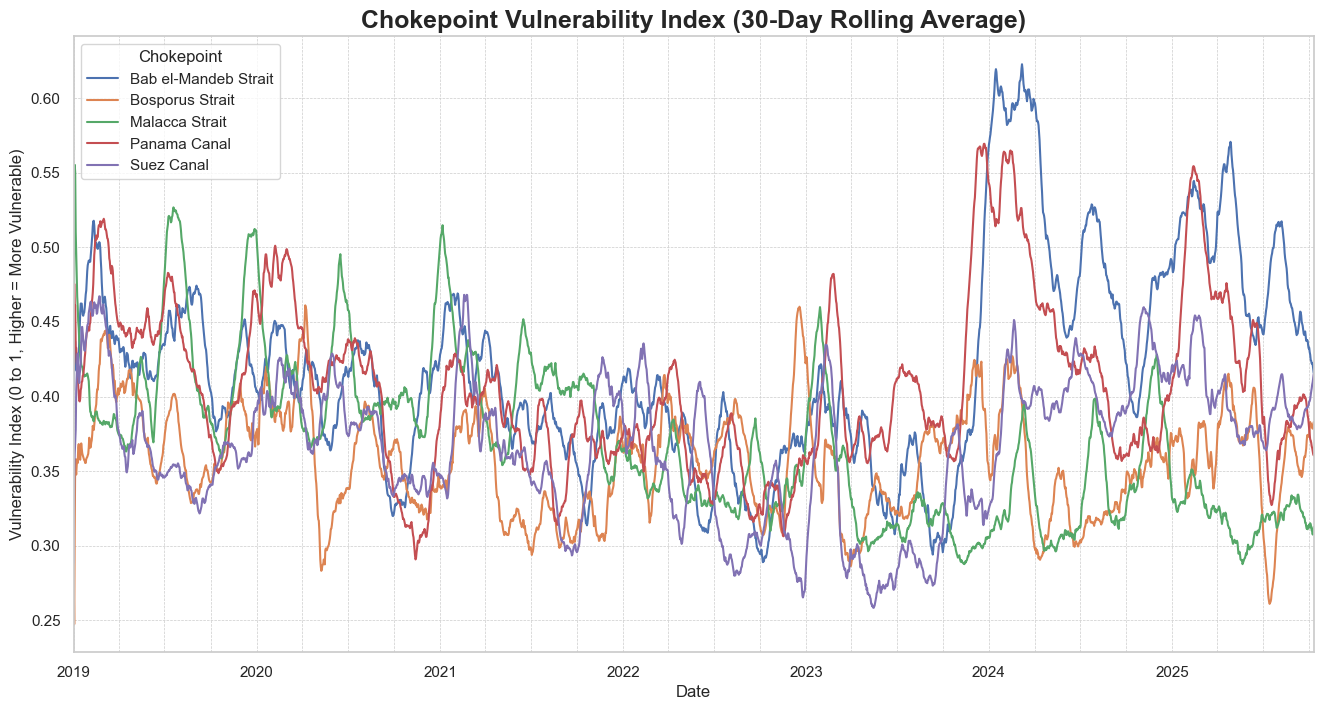

/var/folders/sw/jvm_9vs95tj9mj54z576clt40000gn/T/ipykernel_3783/3046396992.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_vulnerability.index, y=avg_vulnerability.values, palette='rocket')


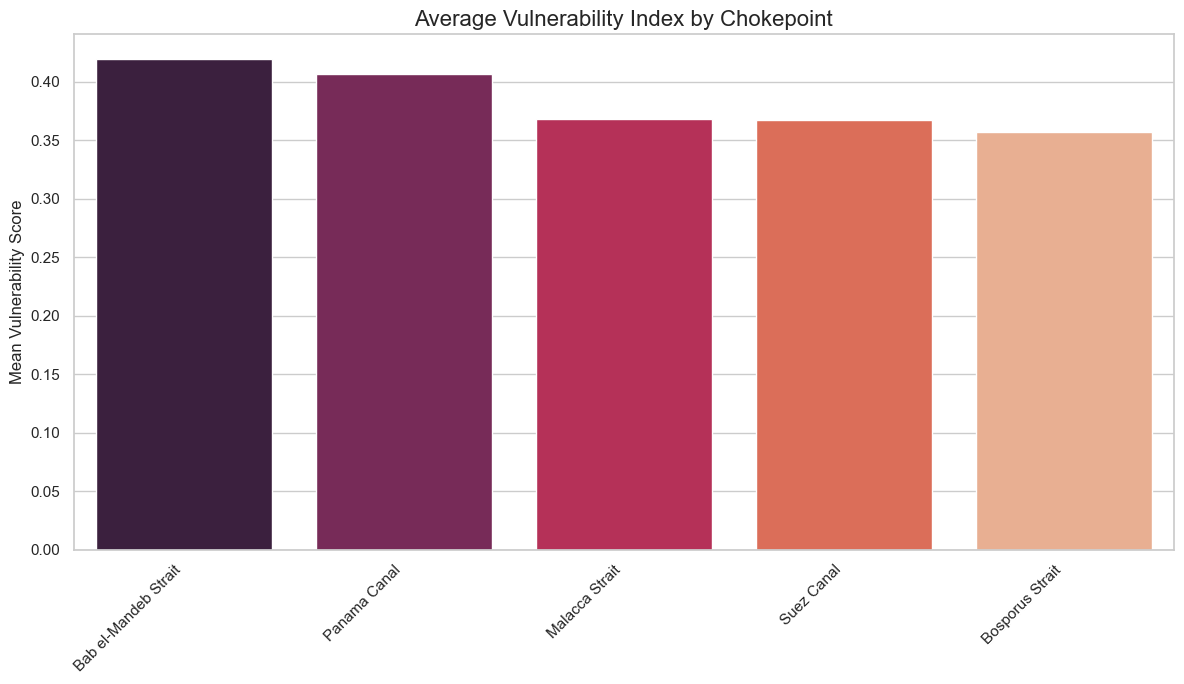


--- Deep Dive: Highest Vulnerability Day for Bab el-Mandeb Strait ---
date                      2024-02-15 00:00:00
vulnerability_index                  0.719788
norm_traffic_stress                  0.511584
norm_weather_stress                  0.822017
norm_geopolitical_risk               0.840366
Name: 1871, dtype: object


In [ ]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)

# Plot 1: The Vulnerability Index Over Time
# plot a 30-day rolling average to see the major trends.

plt.figure()
for name, group in master_df.groupby('chokepoint_name'):
    # Ensure there are no NaNs before rolling
    group = group.set_index('date').sort_index()
    group['vulnerability_index'].rolling('30D').mean().plot(label=name)

plt.title('Chokepoint Vulnerability Index (30-Day Rolling Average)', fontsize=18, fontweight='bold')
plt.ylabel('Vulnerability Index (0 to 1, Higher = More Vulnerable)')
plt.xlabel('Date')
plt.legend(title='Chokepoint')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


# Plot 2: Comparing Average Vulnerability
# A bar chart to see which chokepoints were, on average, the most vulnerable over the period.

plt.figure(figsize=(12, 7))
avg_vulnerability = master_df.groupby('chokepoint_name')['vulnerability_index'].mean().sort_values(ascending=False)

sns.barplot(x=avg_vulnerability.index, y=avg_vulnerability.values, palette='rocket')
plt.title('Average Vulnerability Index by Chokepoint', fontsize=16)
plt.ylabel('Mean Vulnerability Score')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

bab_el_mandeb_df = master_df[master_df['chokepoint_name'] == 'Bab el-Mandeb Strait']
if not bab_el_mandeb_df.empty:
    highest_risk_day = bab_el_mandeb_df.loc[bab_el_mandeb_df['vulnerability_index'].idxmax()]

    print("\n--- Deep Dive: Highest Vulnerability Day for Bab el-Mandeb Strait ---")
    print(highest_risk_day[['date', 'vulnerability_index', 'norm_traffic_stress', 'norm_weather_stress', 'norm_geopolitical_risk']])
else:
    print("\n--- Could not perform deep dive for Bab el-Mandeb Strait (no data). ---")



--- Correlation Between Stress Components ---
Correlation Matrix (1 = perfect positive correlation, -1 = perfect negative correlation):


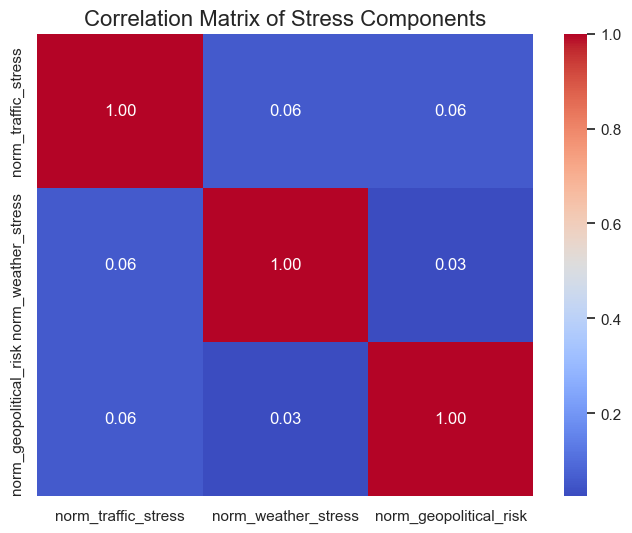

In [ ]:
# Correlation Analysis
print("\n\n--- Correlation Between Stress Components ---")
# Does bad weather correlate with low traffic? Does high geopolitical risk correlate with low traffic?
correlation_matrix = master_df[['norm_traffic_stress', 'norm_weather_stress', 'norm_geopolitical_risk']].corr()
print("Correlation Matrix (1 = perfect positive correlation, -1 = perfect negative correlation):")

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Stress Components', fontsize=16)
plt.show()


--- Distribution of Vulnerability by Chokepoint ---
This plot compares the stability of each chokepoint. Wider boxes and more outliers mean more volatility.


/var/folders/sw/jvm_9vs95tj9mj54z576clt40000gn/T/ipykernel_3783/3659164374.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=master_df, x='chokepoint_name', y='vulnerability_index', palette='viridis')


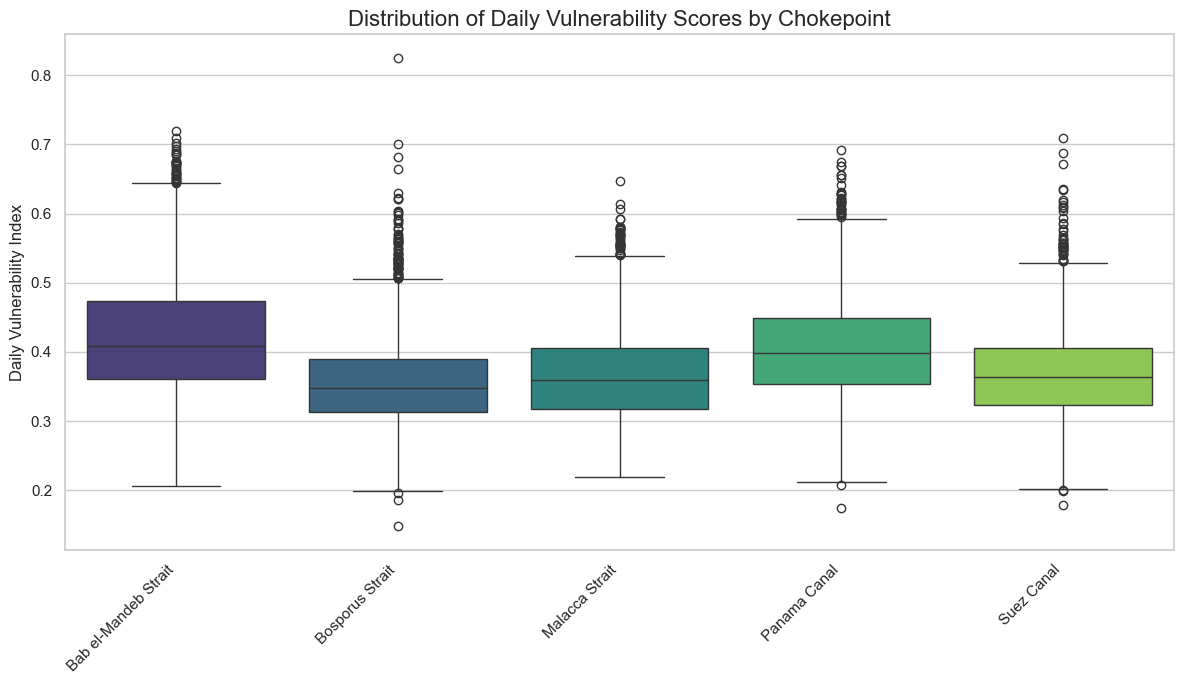

In [31]:
# Boxplot of Vulnerability Score Distributions

print("\n--- Distribution of Vulnerability by Chokepoint ---")
print("This plot compares the stability of each chokepoint. Wider boxes and more outliers mean more volatility.")

plt.figure(figsize=(12, 7))

sns.boxplot(data=master_df, x='chokepoint_name', y='vulnerability_index', palette='viridis')

plt.title('Distribution of Daily Vulnerability Scores by Chokepoint', fontsize=16)
plt.ylabel('Daily Vulnerability Index')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


--- Average Contribution of Each Stress Component ---
This plot shows what factors, on average, drive the vulnerability score for each location.


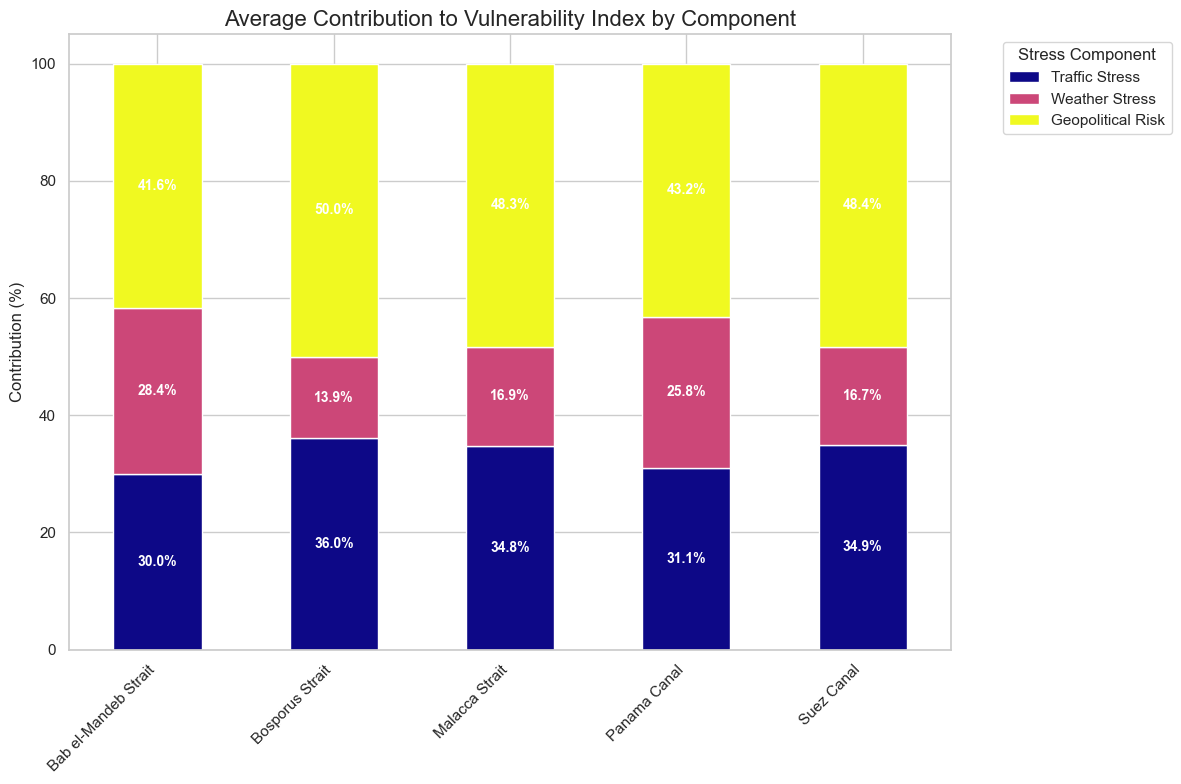

In [ ]:
# Stacked Bar Chart of Vulnerability Drivers
print("\n--- Average Contribution of Each Stress Component ---")
print("This plot shows what factors, on average, drive the vulnerability score for each location.")

driver_analysis_pct = master_df.groupby('chokepoint_name')[['norm_traffic_stress', 'norm_weather_stress', 'norm_geopolitical_risk']].mean()
driver_analysis_pct = driver_analysis_pct.div(driver_analysis_pct.sum(axis=1), axis=0) * 100

driver_analysis_pct.rename(columns={
    'norm_traffic_stress': 'Traffic Stress',
    'norm_weather_stress': 'Weather Stress',
    'norm_geopolitical_risk': 'Geopolitical Risk'
}, inplace=True)

# Plotting the stacked bar chart
ax = driver_analysis_pct.plot(
    kind='bar', 
    stacked=True, 
    figsize=(12, 8), 
    colormap='plasma'
)

plt.title('Average Contribution to Vulnerability Index by Component', fontsize=16)
plt.ylabel('Contribution (%)')
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stress Component', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels to each bar segment
for c in ax.containers:
    labels = [f'{w:.1f}%' if w > 0 else '' for w in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center', color='white', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
print("\n--- Saving the Final Master DataFrame ---")

# Define the path for the output file
output_dir_processed = 'processed_data'
os.makedirs(output_dir_processed, exist_ok=True) # Ensure the directory exists
final_master_df_path = os.path.join(output_dir_processed, 'master_df.csv')

# We drop the geometry and any other non-essential columns if they exist
if 'geometry' in master_df.columns:
    master_df.drop(columns=['geometry']).to_csv(final_master_df_path, index=False)
else:
    master_df.to_csv(final_master_df_path, index=False)

print(f"\nMaster DataFrame successfully saved to: {final_master_df_path}")


--- Saving the Final Master DataFrame ---

Master DataFrame successfully saved to: processed_data/master_df.csv
